# Lorenz System LSTM Predictor Demo

This notebook demonstrates the usage of the LSTM-based predictor for the Lorenz system.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from lorenz_lstm.lorenz_system import generate_lorenz_data
from lorenz_lstm.data import prepare_sequence_data_loaders
from lorenz_lstm.model import LorenzLSTM
from lorenz_lstm.train import train_model
from lorenz_lstm.visualization import (
    plot_training_history,
    plot_3d_trajectories,
    plot_time_series
)

## 1. Generate Lorenz System Data

In [2]:
# Parameters
t_span = (0, 30)
base_initial_xyz = [1, 1, 1]
num_trajectories = 200
perturbation_scale = 10
num_points = 3000

# Generate data
lorenz_data, t_eval = generate_lorenz_data(
    t_span, base_initial_xyz, num_trajectories,
    perturbation_scale, num_points
)

## 2. Prepare Data Loaders

In [ ]:
sequence_length = 10
batch_size = 500

train_loader, val_loader, test_loader = prepare_sequence_data_loaders(
    lorenz_data, sequence_length, batch_size, train_split=0.8, val_split=0.1
)

train_size = int(len(lorenz_data) * 0.8)
val_size = int(len(lorenz_data) * 0.1)
test_size = int(len(lorenz_data) * 0.1)

print(f"Train size: {train_size}")
print(f"Validation size: {val_size}")
print(f"Test size: {test_size}")


In [37]:
train_size = int(len(lorenz_data) * 0.8)
val_size = int(len(lorenz_data) * 0.1)
test_size = int(len(lorenz_data) * 0.1)

print(f"Train size: {train_size}")
print(f"Validation size: {val_size}")
print(f"Test size: {test_size}")

Train size: 160
Validation size: 20
Test size: 20


## 3. Train the Model

Epoch 1/10: 100%|██████████| 957/957 [00:31<00:00, 30.49it/s]


Epoch 1: Train Loss = 88.9026, Val Loss = 21.7259


Epoch 2/10: 100%|██████████| 957/957 [00:33<00:00, 28.45it/s]


Epoch 2: Train Loss = 10.4338, Val Loss = 4.5541


Epoch 3/10: 100%|██████████| 957/957 [00:34<00:00, 27.95it/s]


Epoch 3: Train Loss = 2.6623, Val Loss = 1.4177


Epoch 4/10: 100%|██████████| 957/957 [00:33<00:00, 28.44it/s]


Epoch 4: Train Loss = 0.9128, Val Loss = 0.5450


Epoch 5/10: 100%|██████████| 957/957 [00:35<00:00, 26.84it/s]


Epoch 5: Train Loss = 0.3868, Val Loss = 0.2508


Epoch 6/10: 100%|██████████| 957/957 [00:30<00:00, 31.02it/s]


Epoch 6: Train Loss = 0.1942, Val Loss = 0.1336


Epoch 7/10: 100%|██████████| 957/957 [00:34<00:00, 27.38it/s]


Epoch 7: Train Loss = 0.1107, Val Loss = 0.0804


Epoch 8/10: 100%|██████████| 957/957 [00:33<00:00, 28.34it/s]


Epoch 8: Train Loss = 0.0687, Val Loss = 0.0492


Epoch 9/10: 100%|██████████| 957/957 [00:37<00:00, 25.56it/s]


Epoch 9: Train Loss = 0.0446, Val Loss = 0.0312


Epoch 10/10: 100%|██████████| 957/957 [00:35<00:00, 26.68it/s]


Epoch 10: Train Loss = 0.0290, Val Loss = 0.0193


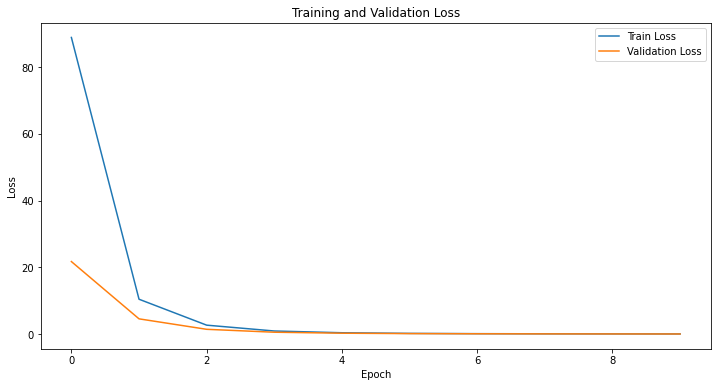

In [5]:
# Initialize model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LorenzLSTM().to(device)

# Train
num_epochs = 10
history = train_model(model, train_loader, val_loader, num_epochs, device=device)

# Plot training history
plot_training_history(history)

## 4. Generate and Visualize Predictions

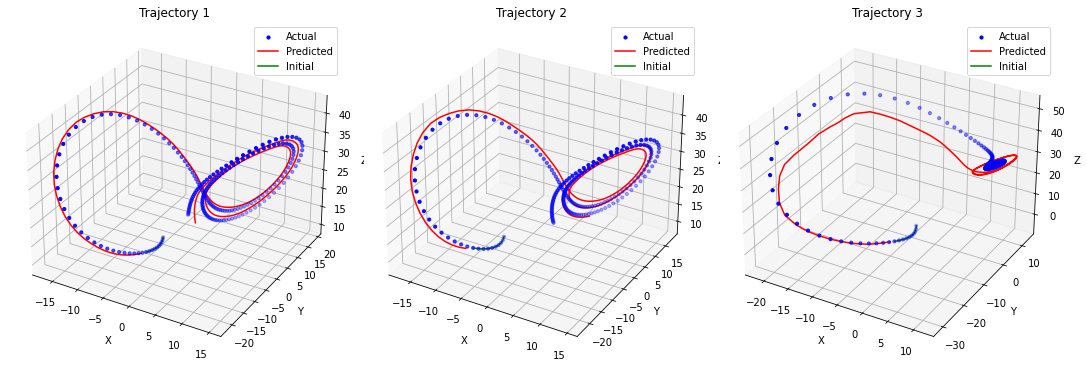

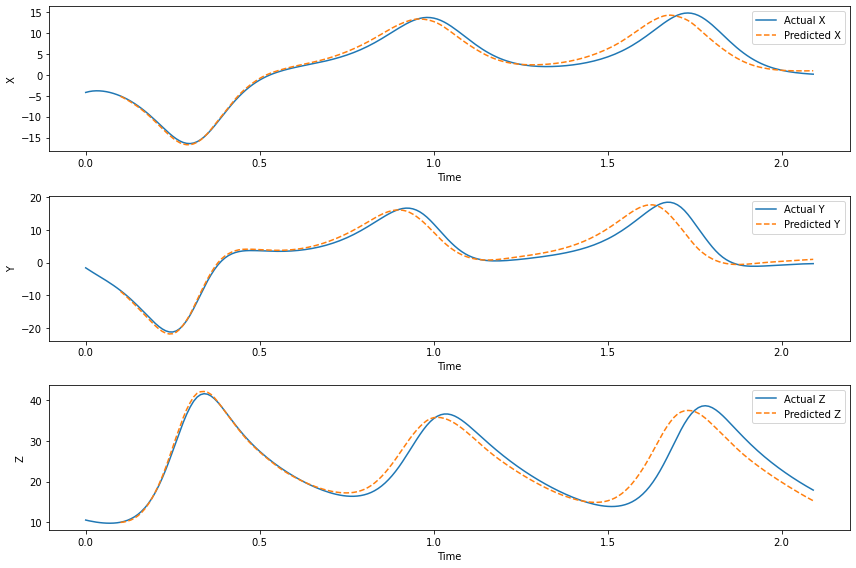

In [69]:
# Parameters for prediction
initial_trajectory = 15
num_test_trajectories = 3
num_predictions = 200

actual_trajectories = []
predicted_trajectories = []
initial_sequences = []

# Get test sequences
test_data = lorenz_data[-test_size:]
for i in range(initial_trajectory, initial_trajectory + num_test_trajectories):
    initial_sequence = torch.tensor(test_data[i][:sequence_length], dtype=torch.float32).unsqueeze(0)
    
    # We only need one sequence for prediction
    current_input = initial_sequence  # Keep batch dimension but use only first sequence
    
    # Store initial sequence without batch dimension for plotting
    initial_sequences.append(test_data[i][:sequence_length])
    
    # Generate predictions
    predictions = []
    
    for _ in range(num_predictions):
        with torch.no_grad():
            output = model(current_input)  # Shape: [1, 3]
            predictions.append(output[0].cpu().numpy())  # Get the prediction for the single sequence
            
            # Reshape output to match current_input dimensions [1, 1, 3]
            next_step = output.view(1, 1, 3)
            
            # Update input sequence for next prediction
            current_input = torch.cat([current_input[:, 1:], next_step], dim=1)
    
    predicted_trajectory = np.array(predictions)
    
    # Get corresponding actual trajectory
    actual_trajectory = test_data[i]  # Use last few trajectories
    actual_trajectory = actual_trajectory[:num_predictions + sequence_length]
    
    actual_trajectories.append(actual_trajectory)
    predicted_trajectories.append(predicted_trajectory)

# Convert to numpy arrays for consistent handling
actual_trajectories = np.array(actual_trajectories)
predicted_trajectories = np.array(predicted_trajectories)
initial_sequences = np.array(initial_sequences)

# Plot 3D trajectories
plot_3d_trajectories(actual_trajectories, predicted_trajectories, initial_sequences)

# Plot time series
plot_time_series(t_eval, actual_trajectories[0], predicted_trajectories[0], sequence_length)